<a href="https://colab.research.google.com/github/eduardoprospero/IC/blob/main/IC_Visualiza%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Seleção

In [5]:
#Seleção do arquivo

#nome = "Instance1.txt"
#nome = "Instance2.txt"
#nome = "Instance3.txt"
#nome = "Instance4.txt"
#nome = "Instance5.txt"
#nome = "Instance6.txt"
#nome = "Instance7.txt"
nome = "Instance8.txt"
#nome = "Instance9.txt"
#nome = "Instance10.txt"
#nome = "Instance11.txt"
#nome = "Instance12.txt"
#nome = "Instance13.txt"
#nome = "Instance14.txt"
#nome = "Instance15.txt"
#nome = "Instance16.txt"
#nome = "Instance17.txt"
#nome = "Instance18.txt"
#nome = "Instance19.txt"
#nome = "Instance20.txt"
#nome = "Instance21.txt"
#nome = "Instance22.txt"
#nome = "Instance23.txt"
#nome = "Instance24.txt"

##Leitura dos dados

In [7]:
from inrc2_txt import read_inrc2_txt
from inrc2_json import read_inrc2_json
from inrc2_xml import read_inrc2_xml
#from outros_ros import processaRos, processaRos_ortec, processaRos_gpost, processaRos_whpp, processaRos_valouxis
from inrc1 import read_inrc1
from vq import read_vq

def didntCollectWell(nome_modelo):

	if(nome_modelo.upper() == "KEREM-IPVN"):
		return 0, {}, {}
	else:
		print("Inacessível")

def sul(origem_dados, nome_modelo, caminhos, especificacao = "NaoHa"):

	valido = True

	if(origem_dados.upper() == "INRC2"):
		print("Origem dos dados: INRC2")
	elif(origem_dados.upper() == "OUTROS"):
		print("Origem dos dados: OUTROS ("+especificacao+")")
	elif(origem_dados.upper() == "INRC1"):
		print("Origem dos dados: INRC1")
	elif(origem_dados.upper() == "VQ"):
		print("Origem dos dados: VQ")
	else:
		print("Erro! Origem dos dados desconhecida")
		valido = False
		
	if(nome_modelo.upper() == "KEREM-IPVN"): #a hybrid Integer Programming and Variable Neighbourhood search algorithm to solve nurse rosteing problems
		print("Modelo: a hybrid Integer Programming and Variable Neighbourhood search algorithm to solve nurse rosteing problems")
	else:
		print("Erro! Modelo utilizado desconhecido")
		valido = False
	
	if(not valido):
		if(nome_modelo.upper() == "KEREM-IPVN"):
			return 0, {}, {} #erro, nenhum set, nenhum parâmetro
		print("Nada será retornado!")
		
	else:
				
		if(origem_dados.upper() == "INRC2"):
			
			c_coleta = 1
			
			if(caminhos[0].upper() == "TXT"):
				c_coleta, arquivo_cenario, arquivos_semana, arquivo_historico = read_inrc2_txt(caminhos[1], caminhos[2], caminhos[3])
			elif(caminhos[0].upper() == "JSON"):
				c_coleta, arquivo_cenario, arquivos_semana, arquivo_historico = read_inrc2_json(caminhos[1], caminhos[2], caminhos[3])
			elif(caminhos[0].upper() == "XML"):
				c_coleta, arquivo_cenario, arquivos_semana, arquivo_historico = read_inrc2_xml(caminhos[1], caminhos[2], caminhos[3])
			else:
				print("Erro! Formato de arquivo desconhecido")
				c_coleta = 0
				
			if(not c_coleta):
				
				didntCollectWell(nome_modelo)
				
			else:			
				return createFrom_inrc2_TO_kerem_ipvn(arquivo_cenario, arquivos_semana, arquivo_historico)
				
		elif(origem_dados.upper() == "OUTROS"):
			c, r, a = processaRos(caminhos)
			
			if(not c):
			
				didntCollectWell(nome_modelo)
				
			else:
			
				if(especificacao.upper() == "ORTEC"):
					tudo = processaRos_ortec(r, a)
					
				elif(especificacao.upper() == "GPOST"):
					tudo = processaRos_gpost(r, a)
					
				elif(especificacao.upper() == "WHPP"):
					tudo = processaRos_whpp(r, a)
					
				elif(especificacao.upper() == "VALOUXIS"):
					tudo = processaRos_valouxis(r, a)
					
				return createFrom_outros_TO_kerem_ipvn(tudo)
				
		elif(origem_dados.upper() == "INRC1"):
			c, a, historico = read_inrc1(caminhos)
			
			if(not c):
			
				didntCollectWell(nome_modelo)
				
			else:
				return createFrom_inrc1_TO_kerem_ipvn(a, historico)
				
		elif(origem_dados.upper() == "VQ"):
			c, a = read_vq(caminhos)
			
			if(not c):
			
				didntCollectWell(nome_modelo)
				
			else:
				return createFrom_vq_TO_kerem_ipvn(a)
					
		else:
			print("Inacessível")

def createFrom_inrc2_TO_kerem_ipvn(arquivo_cenario, arquivos_semana, arquivo_historico):

	conjuntos = {}
	parametros = {}
	
	#cunjunto de dias
	conjuntos["D"] = []
	for i in range(7*arquivo_cenario["horizonte"]):
		conjuntos["D"].append(i)
	#cunjunto de semanas
	conjuntos["W"] = []
	for i in range(arquivo_cenario["horizonte"]):
		conjuntos["W"].append(i)
	#cunjunto de enfermeiras
	conjuntos["I"] = []
	for nurse in arquivo_cenario["nurses"]:
		conjuntos["I"].append(nurse)
	#cunjunto de turnos
	conjuntos["T"] = []
	for turno in arquivo_cenario["turnos"]:
		conjuntos["T"].append(turno)
	#cunjunto de sequências proibidas de turnos
	conjuntos["R_t"] = arquivo_cenario["forbidden"]
	#conjunto de dias que a enfermeira i \in I não pode ser alocada
	conjuntos["N_i"] = []
	for nurse in conjuntos["I"]:
		conjuntos["N_i"].append([])
	for i in range(len(arquivos_semana)):
		for j in range(len(conjuntos["I"])):
			for k in range(7):
				conta = 0
				for l in range(len(conjuntos["T"])):
					conta += arquivos_semana[i]["shiftsOffRequirement"][j][l][k]
				if(conta == len(conjuntos["T"])):
					conjuntos["N_i"][j].append(7*i+k)
	'''
	duração do turno t \in T em minutos
		terá valor 1 por não ser expresso nos arquivos de dados
	'''
	parametros["l_t"] = []
	for turno in conjuntos["T"]:
		parametros["l_t"].append(1)
	'''
	quantidade máxima de turnos do tipo t \in T que a enfermeira i \in I pode ser alocada
		terá valor igual a dias por não ser expresso nos arquivos de dados
	'''
	parametros["m_max"] = []
	for nurse in conjuntos["I"]:
		parametros["m_max"].append([])
		for turno in conjuntos["T"]:
			parametros["m_max"][-1].append(len(conjuntos["D"]))
	'''
	quantidade mínima de minutos que a enfermeira i \in I deve trabalhar no horizonte
		terá valor de alocações mínima que a enfermeira deve ter por não ser expresso nos arquivos de dados
	'''
	parametros["b_min"] = []
	for i in range(len(conjuntos["I"])):
		parametros["b_min"].append(0)
		for j in range(len(arquivo_cenario["contratos"])):
			if(arquivo_cenario["nursesContratos"][i][j]):
				parametros["b_min"][-1] = arquivo_cenario["assignments"][j][0]
	'''
	quantidade máxima de minutos que a enfermeira i \in I deve trabalhar no horizonte
		terá valor de alocações máxima que a enfermeira deve ter por não ser expresso nos arquivos de dados
	'''
	parametros["b_max"] = []
	for i in range(len(conjuntos["I"])):
		parametros["b_max"].append(0)
		for j in range(len(arquivo_cenario["contratos"])):
			if(arquivo_cenario["nursesContratos"][i][j]):
				parametros["b_max"][-1] = arquivo_cenario["assignments"][j][1]
	#quantidade mínima de turnos seguidos que a enfermeira i \in I deve trabalhar
	parametros["c_min"] = []
	for i in range(len(conjuntos["I"])):
		parametros["c_min"].append(0)
		for j in range(len(arquivo_cenario["contratos"])):
			if(arquivo_cenario["nursesContratos"][i][j]):
				parametros["c_min"][-1] = arquivo_cenario["consecutivoContratos"][j][0]
	#quantidade máxima de turnos seguidos que a enfermeira i \in I deve trabalhar
	parametros["c_max"] = []
	for i in range(len(conjuntos["I"])):
		parametros["c_max"].append(0)
		for j in range(len(arquivo_cenario["contratos"])):
			if(arquivo_cenario["nursesContratos"][i][j]):
				parametros["c_max"][-1] = arquivo_cenario["consecutivoContratos"][j][1]
	#quantidade mínima de dias consecutivos de folga que a enfermeira i \in I pode ter
	parametros["o_min"] = []
	for i in range(len(conjuntos["I"])):
		parametros["o_min"].append(0)
		for j in range(len(arquivo_cenario["contratos"])):
			if(arquivo_cenario["nursesContratos"][i][j]):
				parametros["o_min"][-1] = arquivo_cenario["consecutivaFolgaContratos"][j][0]
	#número máximo de fins de semana que a enfermeira i \in I pode trabalhar
	parametros["a_max"] = []
	for i in range(len(conjuntos["I"])):
		parametros["a_max"].append(0)
		for j in range(len(arquivo_cenario["contratos"])):
			if(arquivo_cenario["nursesContratos"][i][j]):
				parametros["a_max"][-1] = arquivo_cenario["limiteFinsSemanaTrabalhados"][j]
	
	'''
	penalidade por não alocar certa enfermeira em dado turno de dado dia
		terá valor 0 por não ser expresso nos arquivos de dados
	'''
	parametros["q"] = []
	for nurse in conjuntos["I"]:
		parametros["q"].append([])
		for dia in conjuntos["D"]:
			parametros["q"][-1].append([])
			for turno in conjuntos["T"]:
				parametros["q"][-1][-1].append(0)
	'''
	penalidade por alocar certa enfermeira em dado turno de dado dia
		terá valor 1 quando necessário por não serem dados pesos distintos nos arquivos de dados
	'''
	parametros["p"] = []
	for nurse in conjuntos["I"]:
		parametros["p"].append([])
		for dia in conjuntos["D"]:
			parametros["p"][-1].append([])
			for turno in conjuntos["T"]:
				parametros["p"][-1][-1].append(0)
	for i in range(len(arquivos_semana)):
		for j in range(len(conjuntos["I"])):
			for k in range(len(conjuntos["T"])):
				for l in range(7):
					parametros["p"][j][7*i+l][k] = arquivos_semana[i]["shiftsOffRequirement"][j][k][l]
	'''
	demanda do dia
		será a soma da quantidade de enfermeiras de cada habilidade (valor ótimo, o valor mínimo será "descartado")
	'''
	parametros["u"] = []
	for dia in conjuntos["D"]:
		parametros["u"].append([])
		for turno in conjuntos["T"]:
			parametros["u"][-1].append(0)
	for i in range(len(arquivos_semana)):
		for j in range(7):
			for k in range(len(conjuntos["T"])):
				for l in range(arquivo_cenario["quantidadeHabilidades"]):
					parametros["u"][7*i+j][k] += arquivos_semana[i]["demanda"][k][l][j][1]
	'''
	penalidade por alocar menos que a quantidade desejada de enfermeiras para certo turno de certo dia
		terá valor 1 por não ser expresso nos arquivos de dados
	'''
	parametros["w_min"] = []
	for dia in conjuntos["D"]:
		parametros["w_min"].append([])
		for turno in conjuntos["T"]:
			parametros["w_min"][-1].append(1)
	'''
	penalidade por alocar mais que a quantidade desejada de enfermeiras para certo turno de certo dia
		terá valor 1 por não ser expresso nos arquivos de dados
	'''
	parametros["w_max"] = []
	for dia in conjuntos["D"]:
		parametros["w_max"].append([])
		for turno in conjuntos["T"]:
			parametros["w_max"][-1].append(1)

	return 1, conjuntos, parametros, False
	
def createFrom_outros_TO_kerem_ipvn(arq):
	
	conjuntos = {}
	parametros = {}
	
	#cunjunto de dias
	conjuntos["D"] = []
	for i in range(7*arq["horizonte"]):
		conjuntos["D"].append(i)
	#cunjunto de semanas
	conjuntos["W"] = []
	for i in range(arq["horizonte"]):
		conjuntos["W"].append(i)
	#cunjunto de enfermeiras
	conjuntos["I"] = []
	for nurse in arq["nurses"]:
		conjuntos["I"].append(nurse["nome"])
	#cunjunto de turnos
	conjuntos["T"] = []
	for turno in arq["turnos"]:
		conjuntos["T"].append(turno["nome"])
	#cunjunto de sequências proibidas de turnos
	conjuntos["R_t"] = arq["forbidden"]
	#conjunto de dias que a enfermeira i \in I não pode ser alocada
	conjuntos["N_i"] = []
	for nurse in conjuntos["I"]:
		conjuntos["N_i"].append([])
	aux = []
	for nurse in conjuntos["I"]:
		aux.append([])
		for dia in conjuntos["D"]:
			aux[-1].append([])
			for turno in conjuntos["T"]:
				aux[-1][-1].append(0)
	for escolha in arq["shiftsOffRequirement"]:
		aux[escolha["nurse"]][escolha["posicao"]][escolha["turno"]] = 1
	for i in range(len(conjuntos["I"])):
		for j in range(len(conjuntos["D"])):
			conta = 0
			for k in range(len(conjuntos["T"])):
				conta += aux[i][j][k]
			if(conta == len(conjuntos["T"])):
				conjuntos["N_i"][i].append(j)
	#duração do turno t \in T em minutos
	parametros["l_t"] = []
	for turno in arq["turnos"]:
		parametros["l_t"].append(turno["duracao"])
	#quantidade máxima de turnos do tipo t \in T que a enfermeira i \in I pode ser alocada
	parametros["m_max"] = arq["m_max"]
	
	#quantidade mínima de minutos que a enfermeira i \in I deve trabalhar no horizonte
	parametros["b_min"] = arq["b_min"]
	#quantidade máxima de minutos que a enfermeira i \in I deve trabalhar no horizonte
	parametros["b_max"] = arq["b_max"]
	#quantidade mínima de turnos consecutivos que a enfermeira i \in I deve trabalhar
	parametros["c_min"] = arq["c_min"]
	#quantidade máxima de turnos consecutivos que a enfermeira i \in I deve trabalhar
	parametros["c_max"] = arq["c_max"]
	#quantidade mínima de dias consecutivos de folga que a enfermeira i \in I pode ter
	parametros["o_min"] = arq["o_min"]
	#númerio máximo de fins de semana que a enfermeira i \in I pode trabalhar
	parametros["a_max"] = arq["a_max"]
	
	parametros["q"] = []
	for nurse in conjuntos["I"]:
		parametros["q"].append([])
		for dia in conjuntos["D"]:
			parametros["q"][-1].append([])
			for turno in conjuntos["T"]:
				parametros["q"][-1][-1].append(0)
	for escolha in arq["shiftsOnRequirement"]:
		parametros["q"][escolha["nurse"]][escolha["posicao"]][escolha["turno"]] = escolha["peso"]
	parametros["p"] = []
	for nurse in conjuntos["I"]:
		parametros["p"].append([])
		for dia in conjuntos["D"]:
			parametros["p"][-1].append([])
			for turno in conjuntos["T"]:
				parametros["p"][-1][-1].append(0)
	for escolha in arq["shiftsOffRequirement"]:
		parametros["p"][escolha["nurse"]][escolha["posicao"]][escolha["turno"]] = escolha["peso"]
	parametros["u"] = []
	for i in range(len(conjuntos["W"])):
		for dia in arq["demanda"]:
			parametros["u"].append(dia)
	parametros["w_min"] = []
	for dia in conjuntos["D"]:
		parametros["w_min"].append([])
		for turno in conjuntos["T"]:
			parametros["w_min"][-1].append(arq["coverWeights"][0])
	parametros["w_max"] = []
	for dia in conjuntos["D"]:
		parametros["w_max"].append([])
		for turno in conjuntos["T"]:
			parametros["w_max"][-1].append(arq["coverWeights"][1])
	return 1, conjuntos, parametros, False

def createFrom_inrc1_TO_kerem_ipvn(arq, historico):

	conjuntos = {}
	parametros = {}
	#cunjunto de dias
	conjuntos["D"] = []
	for i in range(arq["quantidadeDias"]):
		conjuntos["D"].append(i)
	#cunjunto de semanas
	conjuntos["W"] = []
	for i in range(arq["horizonte"]):
		conjuntos["W"].append(i)
	#cunjunto de enfermeiras
	conjuntos["I"] = []
	for nurse in arq["nurses"]:
		conjuntos["I"].append(nurse["ID"])
	#cunjunto de turnos
	conjuntos["T"] = []
	for turno in arq["turnos"]:
		conjuntos["T"].append(turno["ID"])
		
	
	#cunjunto de sequências proibidas de turnos
	conjuntos["R_t"] = arq["forbidden"]
	
	#conjunto de dias que a enfermeira i \in I não pode ser alocada
	conjuntos["N_i"] = arq["dontWork"]
	
	#duração do turno t \in T em minutos
	parametros["l_t"] = []
	for turno in arq["turnos"]:
		parametros["l_t"].append(int(turno["duracao"]))
		
	#quantidade máxima de turnos do tipo t \in T que a enfermeira i \in I pode ser alocada
	parametros["m_max"] = arq["m_max"]
	
	#quantidade mínima de SEGUNDOS que a enfermeira i \in I deve trabalhar no horizonte
	parametros["b_min"] = justFill(len(conjuntos["I"]), 0)
	#quantidade máxima de SEGUNDOS que a enfermeira i \in I deve trabalhar no horizonte
	parametros["b_max"] = justFill(len(conjuntos["I"]), arq["quantidadeDias"]*24*60*60)
	#quantidade mínima de turnos consecutivos que a enfermeira i \in I deve trabalhar
	parametros["c_min"] = justFill(len(conjuntos["I"]), 1)
	#quantidade máxima de turnos consecutivos que a enfermeira i \in I deve trabalhar
	parametros["c_max"] = justFill(len(conjuntos["I"]), arq["quantidadeDias"])
	#quantidade mínima de dias consecutivos de folga que a enfermeira i \in I pode ter
	parametros["o_min"] = justFill(len(conjuntos["I"]), 1)
	#númerio máximo de fins de semana que a enfermeira i \in I pode trabalhar
	parametros["a_max"] = justFill(len(conjuntos["I"]), arq["horizonte"])
	
	parametros["q"] = []
	for nurse in conjuntos["I"]:
		parametros["q"].append([])
		for dia in conjuntos["D"]:
			parametros["q"][-1].append([])
			for turno in conjuntos["T"]:
				parametros["q"][-1][-1].append(0)
	parametros["p"] = []
	for nurse in conjuntos["I"]:
		parametros["p"].append([])
		for dia in conjuntos["D"]:
			parametros["p"][-1].append([])
			for turno in conjuntos["T"]:
				parametros["p"][-1][-1].append(0)
	parametros["u"] = arq["demanda"]
	parametros["w_min"] = arq["coverWeights"]
	parametros["w_max"] = arq["coverWeights"]
	
	return 1, conjuntos, parametros, historico

def createFrom_vq_TO_kerem_ipvn(arq):

	conjuntos = {}
	parametros = {}
	#cunjunto de dias
	conjuntos["D"] = []
	for i in range(arq["horizonte"]):
		conjuntos["D"].append(i)
	#cunjunto de semanas
	conjuntos["W"] = []
	for i in range(int(arq["horizonte"] / 7)):
		conjuntos["W"].append(i)
	#cunjunto de enfermeiras
	conjuntos["I"] = arq["nurses"]
	#cunjunto de turnos
	conjuntos["T"] = arq["shifts"]
		
	
	#cunjunto de sequências proibidas de turnos
	conjuntos["R_t"] = arq["r_t"]
	
	#conjunto de dias que a enfermeira i \in I não pode ser alocada
	conjuntos["N_i"] = arq["n_i"]
	
	#duração do turno t \in T em minutos
	parametros["l_t"] = arq["duracoes"]
		
	#quantidade máxima de turnos do tipo t \in T que a enfermeira i \in I pode ser alocada
	parametros["m_max"] = arq["m_max"]
	
	#quantidade mínima de SEGUNDOS que a enfermeira i \in I deve trabalhar no horizonte
	parametros["b_min"] = arq["b_min"]
	#quantidade máxima de SEGUNDOS que a enfermeira i \in I deve trabalhar no horizonte
	parametros["b_max"] = arq["b_max"]
	#quantidade mínima de turnos consecutivos que a enfermeira i \in I deve trabalhar
	parametros["c_min"] = arq["c_min"]
	#quantidade máxima de turnos consecutivos que a enfermeira i \in I deve trabalhar
	parametros["c_max"] = arq["c_max"]
	#quantidade mínima de dias consecutivos de folga que a enfermeira i \in I pode ter
	parametros["o_min"] = arq["o_min"]
	#númerio máximo de fins de semana que a enfermeira i \in I pode trabalhar
	parametros["a_max"] = arq["a_max"]
	
	parametros["q"] = arq["q"]
	parametros["p"] = arq["p"]
	parametros["u"] = arq["demanda"]
	parametros["w_min"] = arq["w_min"]
	parametros["w_max"] = arq["w_max"]
	
	return 1, conjuntos, parametros, False

def justFill(size, value):
	retorno = []
	for i in range(size):
		retorno.append(value)
	return retorno

###a = sul("INRC1", "KEREM-IPVN", "INRC1-DS1/Hospital1-Emergency-Absence.xml")

#a1, b1, c1 = sul("INRC2","KEREM-IPVN", ["JSON", "json_n030w4/Sc-n030w4.json", ["json_n030w4/WD-n030w4-0.json","json_n030w4/WD-n030w4-1.json","json_n030w4/WD-n030w4-2.json","json_n030w4/WD-n030w4-3.json"], "json_n030w4/H0-n030w4-0.json"])
#sul("INRC2","KEREM-IPVN", ["TXT", "txt_n005w4/Sc-n005w4.txt", ["txt_n005w4/WD-n005w4-0.txt","txt_n005w4/WD-n005w4-1.txt","txt_n005w4/WD-n005w4-2.txt","txt_n005w4/WD-n005w4-3.txt"],"txt_n005w4/H0-n005w4-0.txt"])
#sul("INRC2","KEREM-IPVN", ["XML", "xml_n005w4/Sc-n005w4.xml", ["xml_n005w4/WD-n005w4-0.xml","xml_n005w4/WD-n005w4-1.xml","xml_n005w4/WD-n005w4-2.xml","xml_n005w4/WD-n005w4-3.xml"],"xml_n005w4/H0-n005w4-0.xml"])
#d1, e1, f1 = sul("OUTROS", "KEREM-IPVN", "ORTEC01.ros", "ORTEC")
#d2, e2, f2 = sul("OUTROS", "KEREM-IPVN", "GPost.ros", "GPOST")
#d3, e3, f3 = sul("OUTROS", "KEREM-IPVN", "Valouxis-1.ros", "VALOUXIS")
#d4, e4, f4 = sul("OUTROS", "KEREM-IPVN", "WHPP.ros", "WHPP")

a = sul("VQ", "KEREM-IPVN", nome)
a

Origem dos dados: VQ
Modelo: a hybrid Integer Programming and Variable Neighbourhood search algorithm to solve nurse rosteing problems


(1,
 {'D': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27],
  'I': ['A',
   'B',
   'C',
   'D',
   'E',
   'F',
   'G',
   'H',
   'I',
   'J',
   'K',
   'L',
   'M',
   'N',
   'O',
   'P',
   'Q',
   'R',
   'S',
   'T',
   'U',
   'V',
   'W',
   'X',
   'Y',
   'Z',
   'AA',
   'AB',
   'AC',
   'AD'],
  'N_i': [[1, 2],
   [4, 9],
   [16, 17],
   [22, 26],
   [2, 14],
   [26, 27],
   [13, 14],
   [11, 12],
   [13, 14],
   [3, 10],
   [14, 15],
   [9, 14],
   [0, 12],
   [8, 27],
   [14, 24],
   [7, 8],
   [3, 12],
   [4, 7],
   [4, 24],
   [7, 27],
   [21, 22],
   [10, 18],
   [1, 19],
   [3, 4],
   [5, 25],
   [17, 18],
   [23, 24],
   [5, 6],
   [15, 16],
   [15, 16]],
  'R_t': [[0, 0, 0, 0], [1, 0, 0, 0], [1, 1, 0, 0], [1, 1, 1, 0]],
  'T': ['E', 'D', 'L', 'N'],
  'W': [0, 1, 2, 3]},
 {'a_max': [2,
   2,
   2,
   2,
   2,
   2,
   2,
   2,
   

# Visualização dos dados

In [8]:
#visualização dos dados
import matplotlib.pyplot as plt
import numpy as np
import statistics

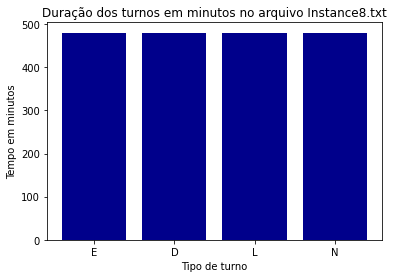

In [9]:
#gráfico turno por tempo em minutos

plt.bar(a[1]['T'], a[2]['l_t'], color = ('darkblue'))
plt.xticks(a[1]['T'])
plt.xlabel("Tipo de turno")
plt.ylabel("Tempo em minutos")
plt.title("Duração dos turnos em minutos no arquivo "+nome)
plt.show()

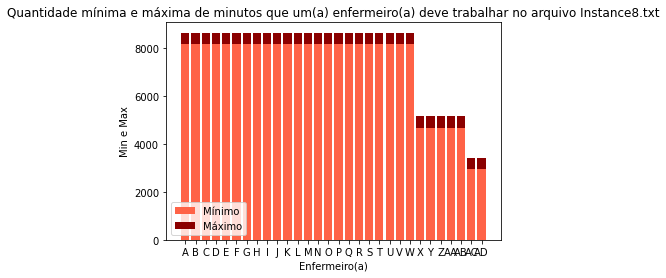

In [10]:
#gráfico da quantidade mínima e máxima de minutos que um(a) enfermeiro(a) deve trabalhar
bmax = a[2]['b_max']
bmin = a[2]['b_min']

sub = list(abs(a - b) for a, b in zip((a[2]["b_max"]), (a[2]["b_min"])))
#sub

plt.bar(a[1]['I'], bmin, color = "tomato")
plt.bar(a[1]['I'], sub, color = "darkred", bottom = bmin)
plt.xlabel('Enfermeiro(a)')
plt.ylabel('Min e Max')
plt.title("Quantidade mínima e máxima de minutos que um(a) enfermeiro(a) deve trabalhar no arquivo "+nome)
plt.legend(('Mínimo', 'Máximo'), loc = 'lower left')
plt.show()

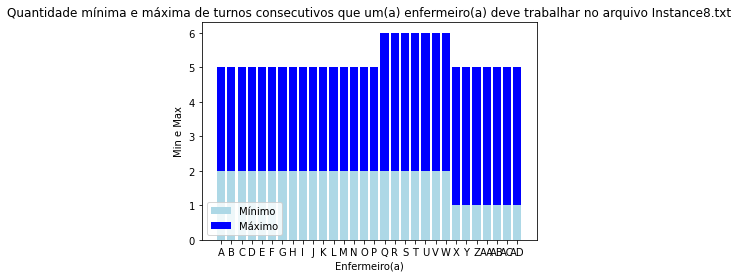

In [11]:
#gráfico da quantidade mínima e máxima de turnos consecutivos que um(a) enfermeiro(a) deve trabalhar
cmax = a[2]['c_max']
cmin = a[2]['c_min']

sub2 = list(abs(a - b) for a, b in zip((a[2]["c_max"]), (a[2]["c_min"])))
#sub

plt.bar(a[1]['I'], cmin, color = "lightblue")
plt.bar(a[1]['I'], sub2, color = "blue", bottom = cmin)
plt.xlabel('Enfermeiro(a)')
plt.ylabel('Min e Max')
plt.title("Quantidade mínima e máxima de turnos consecutivos que um(a) enfermeiro(a) deve trabalhar no arquivo "+nome)
plt.legend(('Mínimo', 'Máximo'), loc = 'lower left')
plt.show()

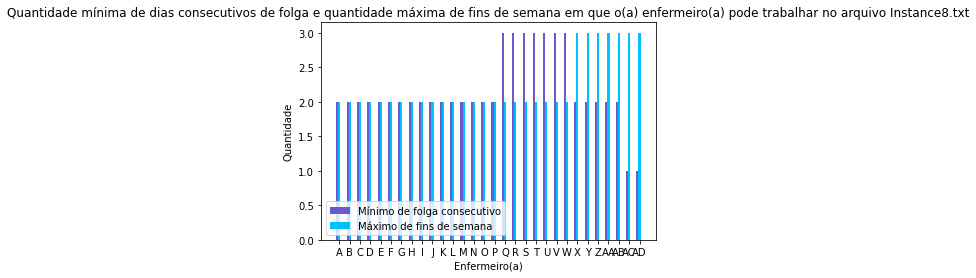

In [12]:
folga = a[2]["o_min"]
finde = a[2]["a_max"]

barWidth = 0.2
r1 = np.arange(len(folga))
r2 = [x + barWidth for x in r1]

plt.bar(r1, folga, color = "#6A5ACD", width = barWidth, label = "Mínimo de folga consecutivo")
plt.bar(r2, finde, color = "#00BFFF", width = barWidth, label = "Máximo de fins de semana")
plt.xticks([r + barWidth for r in range(len(folga))], a[1]["I"])
plt.title("Quantidade mínima de dias consecutivos de folga e quantidade máxima de fins de semana em que o(a) enfermeiro(a) pode trabalhar no arquivo "+nome)
plt.xlabel('Enfermeiro(a)')
plt.ylabel('Quantidade')
plt.legend(loc = 'lower left')
plt.show()

[18.5, 17.25, 17.25, 17.25, 17.0, 18.25, 15.0]


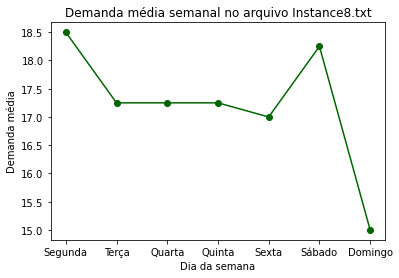

In [13]:
#gráfico da demanda média semanal
dias = len(a[1]['D'])
#print(dias)

x = []
for i in a[2]['u']:
  y = sum(i)
  x.append(y)
#print(x)

d1 = 0
d2 = 0
d3 = 0
d4 = 0
d5 = 0
d6 = 0
d7 = 0

while len(x) != 0:
  d1 = d1 + x[0]
  del x[0]
  d2 = d2 + x[0]
  del x[0]
  d3 = d3 + x[0]
  del x[0]
  d4 = d4 + x[0]
  del x[0]
  d5 = d5 + x[0]
  del x[0]
  d6 = d6 + x[0]
  del x[0]
  d7 = d7 + x[0]
  del x[0]

media_demanda = [d1/(dias/7), d2/(dias/7), d3/(dias/7), d4/(dias/7), d5/(dias/7), d6/(dias/7), d7/(dias/7)]
print(media_demanda)
label = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo']

plt.plot(label, media_demanda, marker = 'o', color = 'darkgreen')
plt.title('Demanda média semanal no arquivo '+nome)
plt.xlabel('Dia da semana')
plt.ylabel('Demanda média')
plt.show()
